# Regional Data Protection Regulation Impact on Chilling Effects Mitigation for Privacy-Sensitive Topics

## Introduction

bla bla

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage,AnnotationBbox
from PIL import Image
from datetime import datetime
from sklearn import linear_model
import seaborn as sns

## Origin of Pageviews

In order to demonstrate the pertinence of studying ```de.wikipedia.org``` in the scope of GDPR impact, we will first take a brief look at the **geographic origin of the pageviews**. Unfortunately, such data is not present in the pageviews dataset we will use later in the scope of our study. As such, we will be using data coming directly from ```stats.wikimedia.org```, which give a monthly overview of the origin of pageviews to specific language versions of Wikipedia.

GDPR affects the whole European Economic Area, not only the European Union. As such, we will highlight in our data pageviews from Germany, Austria, Switzerland, Liechtenstein (the four countries in the world where german is an official language), the rest of the EEA (UK is considered as being still part of the EEA in 2020), and finally the rest of the world. It is of note that *Switzerland is not part of the EEA*; however, since it is landlocked and all of its neighbours EEA members, and since GDPR-compliance is mandatory for selling digital services within the EEA, we can safely consider Switzerland to have been strongly impacted by GDPR too.

In [3]:
# Opening data

nov20 = pd.read_csv("data/11_2020.csv")
nov20.head()

,country,rank,timestamp,total.total,month,timeRange.start,timeRange.end
0,DE,1,1604188800000,763220000,2020-11-01T00:00:00.000Z,2020-11-01T00:00:00.000Z,2020-12-01T00:00:00.000Z
1,AT,2,1604188800000,86708000,2020-11-01T00:00:00.000Z,2020-11-01T00:00:00.000Z,2020-12-01T00:00:00.000Z
2,CH,3,1604188800000,54637000,2020-11-01T00:00:00.000Z,2020-11-01T00:00:00.000Z,2020-12-01T00:00:00.000Z
3,US,4,1604188800000,8359000,2020-11-01T00:00:00.000Z,2020-11-01T00:00:00.000Z,2020-12-01T00:00:00.000Z
4,IT,5,1604188800000,4022000,2020-11-01T00:00:00.000Z,2020-11-01T00:00:00.000Z,2020-12-01T00:00:00.000Z


In [4]:
# Creating country lists

de   = ['DE'] # Germany
at   = ['AT'] # Austria
ch   = ['CH'] # Switzerland
li   = ['LI'] # Liechtenstein
eea  = ['BE', 'BG', 'HR', 'CY', 'CZ', 'DK', 'EE', 'FI', 'FR', 'EL', 'HU', 'IE', 'IT', 'LV',
        'LT','LU','MT', 'NL', 'PL', 'PT', 'RO', 'SK', 'SI', 'ES', 'SE', 'NO', 'IS', 'GB'] # Rest of the EEA
rest = set(nov20[~nov20['country'].isnull()][['country']].values.flatten()) \
            - set(de) - set(at) - set(ch) - set(li) - set(eea) # Rest of the world

countries = [de, at, ch, li, eea, rest]

In [5]:
# Creating pageviews data

pv_origins = pd.DataFrame({'countries':['Germany', 'Austria', 'Switzerland', 'Liechtenstein', 'Rest of the EEA', 'Rest of the World']})
pv_origins['Pageviews (2020)'] = [nov20[nov20['country'].isin(country)][['total.total']].values.sum() for country in countries]
pv_origins

,countries,Pageviews (2020)
0,Germany,763220000
1,Austria,86708000
2,Switzerland,54637000
3,Liechtenstein,306000
4,Rest of the EEA,28822000
5,Rest of the World,22521000


In [6]:
def get_flag(name):
    path = "res/{}.png".format(name)
    im = Image.open(path).resize((24,18))
    im = im.convert("RGBA")
    return im

def offset_image(coord, name, ax):
    img = get_flag(name)
    im = OffsetImage(img)
    im.image.axes = ax

    ab = AnnotationBbox(im, (0, coord),  xybox=(-18., 0.), frameon=False,
                        xycoords='data',  boxcoords="offset points", pad=0)

    ax.add_artist(ab)
    
def add_flags(ax):
    flags = ['DE', 'AT', 'CH', 'LI', 'EU', 'UN']
    ax.tick_params(axis='y', which='major', pad=30)
    for i, f in enumerate(flags):
        offset_image(i, f, ax)
        
def add_prc(ax, values):
    tot = values.sum()
    for i, val in enumerate(values):
        ax.text(val+1e7, i + 0.1, '{:.2f}%'.format(val/tot*100))

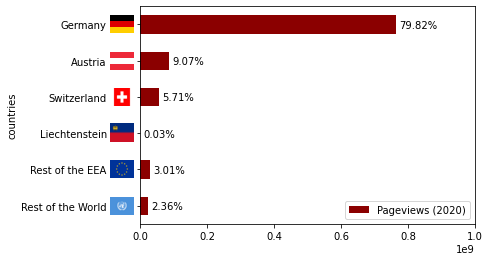

In [7]:
# Plotting data
        
ax = pv_origins.plot.barh('countries', 'Pageviews (2020)', color='darkred')
ax.invert_yaxis()
ax.set_xlim(right=1e9)
add_flags(ax)
add_prc(ax, pv_origins[['Pageviews (2020)']].values.flatten())

We can easily see that **97.64% of total pageviews** on ```de.wikipedia.org``` indeed come from countries strongly affected by GDPR. However, as the month studied is in 2020, it would be possible that COVID-19 changes things as compared to before. As a comparison basis to check it is not the case, we will compare those numbers with the ones of November 2019.

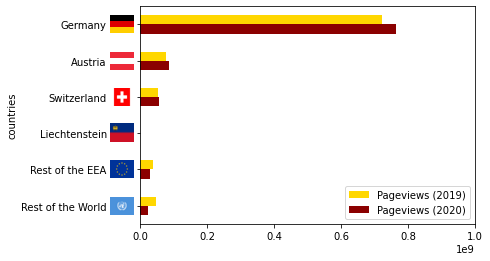

In [8]:
nov19 = pd.read_csv("data/11_2019.csv")
pv_origins['Pageviews (2019)'] = [nov19[nov19['country'].isin(country)][['total.total']].values.sum() for country in countries]

ax = pv_origins.plot.barh('countries', ['Pageviews (2019)','Pageviews (2020)'], color=['gold','darkred'])
ax.invert_yaxis()
ax.set_xlim(right=1e9)
add_flags(ax)

Even though there are a few more views from the rest of the world in 2019 as compared to 2020, it still represents a neglibible portion of those. Moreover, one can guess this rise in pageviews fron the rest of the world come from german-speaking people who travel abroad, and who could not in 2020 because of COVID. Since these people originally would come from GDPR-affected countries, it is reasonable to think they were affected by it. **From those data, we can make the reasonable assumption that nearly all pageviews to ```de.wikipedia.org``` come from GDPR-affected users.**

## Loading data

To find the data, we used the Wikipedia REST API (https://wikimedia.org/api/rest_v1/#/Pageviews%20data), which provides access to Wikimedia content and data, including pageviews.

Some of the pages linked could not be loaded, most of them because there was no data during the epoch (page created afterward), and one because a problem with finding it in the API:
- "Richtlinie 95/46/EG (Datenschutzrichtlinie)": Problem with finding it in the API
- "Google LLC": No data before 09.11.2017
- "Agentur der Europäischen Union für Cybersicherheit":  No data before 07.06.2019 (26.08.2019)
- "GAFAM":  No data before
- "Brüssel-Effekt": No data before 20.01.2019
- "Meme (Kulturphänomen)": No data before 13.10.2019
- "Verordnung (EU) Nr. 910/2014 (eIDAS-Verordnung)":  No data before 11.02.2019
- "Royal Assent":  No data before 31.07.2018
- "Tronc (Unternehmen)":  No data before 02.07.2018
- "NOYB":  No data before 23.01.2019


In [9]:
df = pd.read_json('data/pageviews.json', convert_dates=False)

# Manually convert dates
df.loc[:,'timestamp'] = df.loc[:,'timestamp'].apply(lambda x: datetime(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:8])))
display(df.sample(5))

# Drop useless columns
df = df.drop(['project', 'granularity', 'access', 'agent'], axis=1)
display(df.sample(5))

# Drop articles that have data during only a subset of the period
articles = list(set(df.article))
print("Number of articles before: {}".format(len(articles)))
n = 28

for a in articles:
    if len(df.loc[(df.article == a)]) < 28:
        df = df.loc[(df.article != a)]

articles = list(set(df.article))
print("Number of articles after: {}".format(len(articles)))

,project,article,granularity,timestamp,access,agent,views,rating
1245,de.wikipedia,Charta_der_Grundrechte_der_Europäischen_Union,monthly,2015-08-01,all-access,user,2645,2.42
300,de.wikipedia,Recht_auf_Vergessenwerden,monthly,2017-03-01,all-access,user,1246,3.58
913,de.wikipedia,Cyberattacke,monthly,2015-10-01,all-access,user,540,2.62
1163,de.wikipedia,Instagram,monthly,2015-10-01,all-access,user,68622,2.46
2718,de.wikipedia,Ouija,monthly,2016-08-01,all-access,user,9697,1.23


,article,timestamp,views,rating
758,Privacy_International,2016-11-01,143,2.92
2643,Kalifornien,2017-05-01,53690,1.31
288,Recht_auf_Vergessenwerden,2016-03-01,1439,3.58
872,Datenverarbeitung,2017-01-01,3427,2.77
2321,Chicago_Tribune,2015-11-01,364,1.54


Number of articles before: 102
Number of articles after: 95


In [10]:
def sum_articles(df):
    '''Group the viewcount per month & keep only date and views columns
    '''
    # Group per month
    montly_df = df.copy()
    montly_df = montly_df.groupby('timestamp').sum()
    # Change the index from datetime to integer
    dates = np.arange(1, montly_df.shape[0] + 1)
    montly_df.index = dates
    return montly_df

def scatter_views(date, views, colors, labels, y_label, y_ticks, intervention_month):
    
    fig = plt.figure(figsize=(15,8))
    ax = plt.axes()

    for i in range(len(views)):
        plt.scatter(date, views[i], s=100, c=colors[i], label=labels[i])

    # Line to indicate mid-june 2013
    plt.axvline(intervention_month+0.5, color='black')
    plt.text(intervention_month+0.7, np.array(views).max(), "GDPR law", color='black')
    
    # Properties of the plot
    plt.xlim((0,len(date)+1))
    plt.xticks(np.arange(0, len(date)+1, 2))
    plt.yticks(y_ticks)
    plt.grid(axis='y')
    plt.xlabel('Time (Months)', fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.legend(loc='lower left', bbox_to_anchor=(0, -0.25), ncol=2)
    
    return ax

def perform_regression_Lagarde(date, views, intervention_month, display_values=False):
    n = len(date)

    # define feature matrix X    
    x_time = date
    x_intervention = np.zeros(n)
    x_intervention[intervention_month:] = 1
    x_postslope = np.concatenate((np.zeros(intervention_month), np.arange(1, n-intervention_month+1)))

    X = np.array((np.ones(n), x_time, x_intervention, x_postslope)).T
    # Recall: ones*beta_0, x_time*beta_1, x_intervention*beta_2, x_postslope*beta_3

    # define target vector y 
    y = np.array(views)
    
    if display_values:
        a = pd.DataFrame({'y (views)':views, 'ones':np.ones(n), 'time':x_time, 'intervention':x_intervention, 'postslope':x_postslope})
        display(a)
    
    # create linear regression object and fit
    model = linear_model.LinearRegression(fit_intercept=False)
    model.fit(X, y)
    
    return model.predict(X), model.coef_

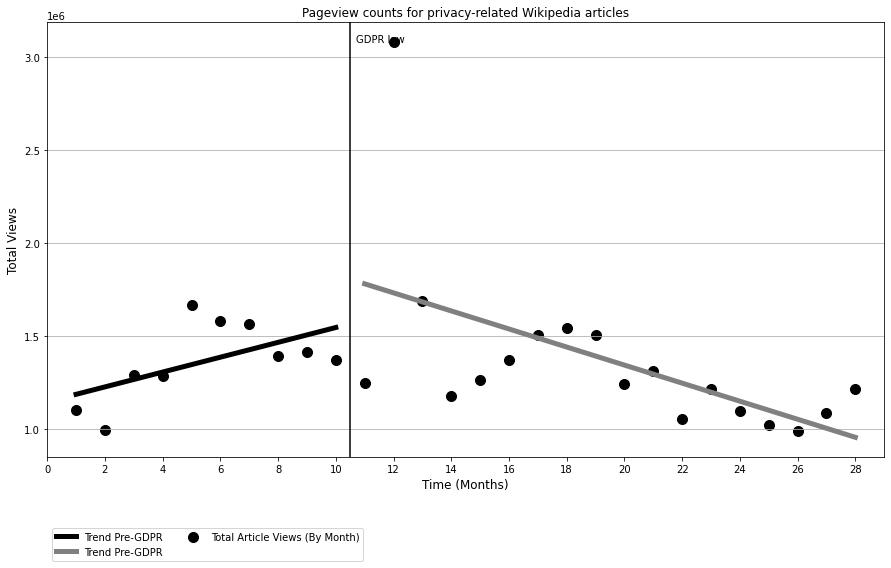

In [30]:
def plot_fig_3(df, columns, y_ticks, intervention_month):
       
    labels = columns
    
    x = df.index
    colors = ['black']
    labels = ['Total Article Views (By Month)', 'Trend Pre-GDPR', 'Trend Post-GDPR']
    y_label = 'Total Views'
    scatter_views(x, np.array(df[columns]).T, colors, [labels[0]], y_label, y_ticks, intervention_month)

    for col in columns:
        y = df[col]
        prediction, coef = perform_regression_Lagarde(x, y, intervention_month, False)

        plt.plot(df.index[:intervention_month], prediction[:intervention_month], label=labels[1], color='black', linewidth=5)
        plt.plot(df.index[intervention_month:], prediction[intervention_month:], label=labels[1], color='grey', linewidth=5)

    plt.legend(loc='lower left', bbox_to_anchor=(0, -0.25), ncol=2)
        
intervention_month = 10
y_ticks = None

df_sum = sum_articles(df)
plot_fig_3(df_sum, ['views'], y_ticks, intervention_month)
plt.title('Pageview counts for privacy-related Wikipedia articles')
plt.show()

## Find and remove outliers

In [22]:
def plot_all_articles(df):
    plt.figure(figsize=(14,8))

    articles = list(set(df.article))
    n = 28
    x = range(1, n+1)

    for article in articles:
        y = df.loc[(df.article == article), 'views']
        plt.scatter(range(1, n+1), y, label=article)

    # Show the outlier months
    #plt.axvline(13, color='black', alpha=0.1)
    #plt.axvline(25, color='black', alpha=0.1)

    plt.xticks(np.arange(0, n+1, 2))
    plt.xlabel('Time (Months)')
    plt.ylabel('Total Article Views')
    #plt.legend(loc='upper right', bbox_to_anchor=(1.8,1))

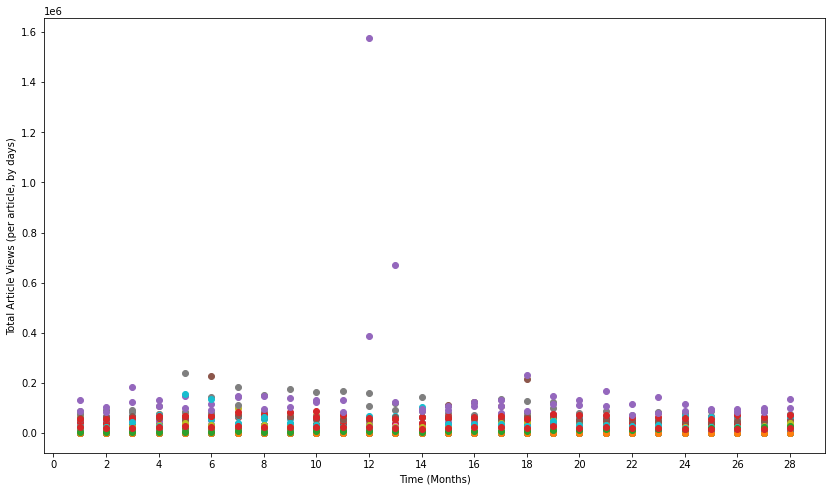

In [23]:
plot_all_articles(df)

In [32]:
df

,article,timestamp,views,rating
0,Datenschutzrecht,2015-07-01,1078,4.23
1,Datenschutzrecht,2015-08-01,951,4.23
2,Datenschutzrecht,2015-09-01,1218,4.23
3,Datenschutzrecht,2015-10-01,1541,4.23
4,Datenschutzrecht,2015-11-01,1670,4.23
...,...,...,...,...
2784,Weihnachtsmann,2017-06-01,4181,1.15
2785,Weihnachtsmann,2017-07-01,4056,1.15
2786,Weihnachtsmann,2017-08-01,4702,1.15
2787,Weihnachtsmann,2017-09-01,6317,1.15


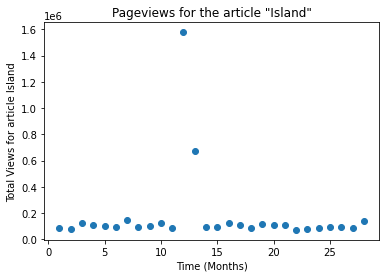

In [38]:
y = df.loc[(df.article == 'Island'), 'views']
plt.scatter(range(1, n+1), y)
plt.title('Pageviews for the article "Island"')
plt.xlabel('Time (Months)')
plt.ylabel('Total Views for article Island')
plt.show()

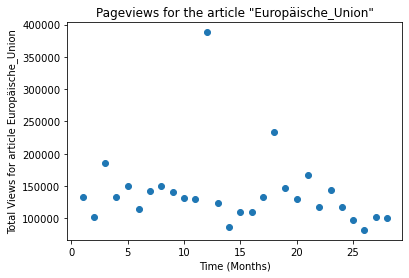

In [39]:
y = df.loc[(df.article == 'Europäische_Union'), 'views']
plt.scatter(range(1, n+1), y)
plt.title('Pageviews for the article "Europäische_Union"')
plt.xlabel('Time (Months)')
plt.ylabel('Total Views for article Europäische_Union')
plt.show()

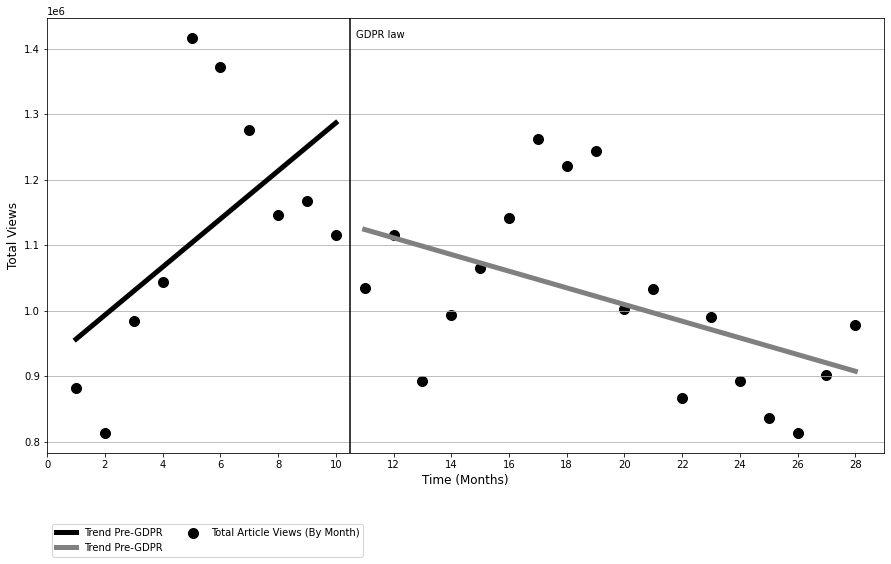

In [41]:
df_no_outlier = df.loc[(df.article != 'Island') & (df.article != 'Europäische_Union')]
df_sum = sum_articles(df_no_outlier)

plot_fig_3(df_sum, ['views'], y_ticks, intervention_month)

In [42]:
df_best = df_no_outlier.loc[df_no_outlier.rating >= 3].drop(['rating'], axis=1)
df_control = df_no_outlier.loc[df_no_outlier.rating <= 2].drop(['rating'], axis=1)

In [44]:
df_best_monthly = sum_articles(df_best)
df_control_monthly = sum_articles(df_control)

# Merge them into one single dataframe
df_all = pd.DataFrame({'best_views':df_best_monthly.views, 'control_views':df_control_monthly.views}, index=df_best_monthly.index)
df_all.head()

,best_views,control_views
1,111978,445543
2,96958,414971
3,130898,490814
4,150963,490360
5,287923,654994


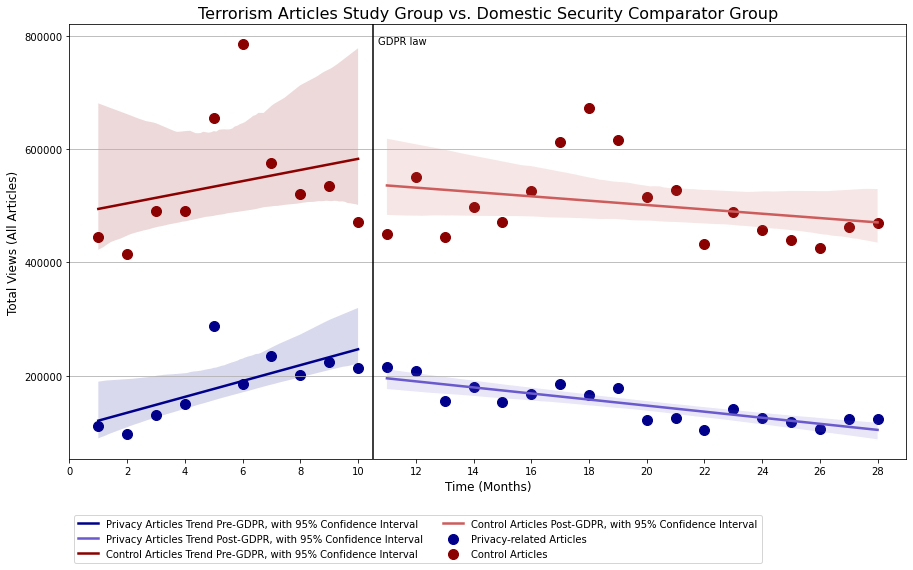

In [45]:
def plot_fig_4A(data, colors, labels, intervention_month):
    
    # Base plot with points
    y_label = 'Total Views (All Articles)'
    y_ticks = np.arange(200000, 1400000, 200000)
    scatter_views(data.index, np.array(data).T, colors[:,0], labels[:,0], y_label, y_ticks, intervention_month)

    for i, col in enumerate(data.columns):
        # Plot trends with 95% CI
        sns.regplot(x=data.index[:intervention_month], y=data[col][:intervention_month], ci=95, scatter=False, color=colors[i][1], label=labels[i][1], line_kws={'linewidth':2.5})
        sns.regplot(x=data.index[intervention_month:], y=data[col][intervention_month:], ci=95, scatter=False, color=colors[i][2], label=labels[i][2], line_kws={'linewidth':2.5})

    plt.xlabel('Time (Months)', fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    
    plt.title('Terrorism Articles Study Group vs. Domestic Security Comparator Group', fontsize=16)
    legend = plt.legend(loc='lower left', bbox_to_anchor=(0, -0.25), ncol=2)
    plt.show()

colors = np.array([['darkblue', 'darkblue', 'slateblue'], ['darkred', 'darkred', 'indianred']])
labels = np.array([['Privacy-related Articles', 'Privacy Articles Trend Pre-GDPR, with 95% Confidence Interval', 'Privacy Articles Trend Post-GDPR, with 95% Confidence Interval'], ['Control Articles', 'Control Articles Trend Pre-GDPR, with 95% Confidence Interval', 'Control Articles Post-GDPR, with 95% Confidence Interval']])

plot_fig_4A(df_all, colors, labels, intervention_month)
plt.show()